# Diving deeper into the BBC News archive

In [1]:
import io
import csv
import zipfile
import tensorflow as tf
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
import matplotlib.pyplot as plt


## Getting data

In [ ]:
# Upload a dataset
files.upload()

In [5]:
# Unzip an archive
zip_ref = zipfile.ZipFile('bbc-text.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
# Check data
ds_file = "./bbc-text.csv"

with open(ds_file, 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

Each data point looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially

## Defining global variables

In [7]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

## Loading and pre-processing the data

In [8]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords
    Args:
        sentence (string): sentence to remove the stopwords from
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    Args:
        filename (string): path to the CSV file
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = remove_stopwords(row[1])
            sentences.append(sentence)

    return sentences, labels

In [9]:
# Test the functions
sentences, labels = parse_data_from_file(ds_file)

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 2225 sentences in the dataset.

First sentence has 436 words (after removing stopwords).

There are 2225 labels in the dataset.

The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


## Training - Validation Split

In [10]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """
    # Compute the number of sentences that will be used for training
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [11]:
# Test the function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1780 sentences for training.

There are 1780 labels for training.

There are 445 sentences for validation.

There are 445 labels for validation.


## Tokenization - Sequences and padding

In [12]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """

    # Instantiate the Tokenizer class
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [13]:
# Test the function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 27285 words

<OOV> token included in vocabulary


In [14]:
# Get padded sequences
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)

    return padded_sequences

In [15]:
# Test the function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1780, 120)

Padded validation sequences have shape: (445, 120)


In [16]:
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    Returns:
        label_seq_np (array of int): tokenized labels
    """

    # Instantiate the Tokenizer
    label_tokenizer = Tokenizer()

    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)

    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)

    # Convert sequences to a numpy array
    label_seq_np = np.array(label_seq) - 1

    return label_seq_np

In [17]:
# Test the function
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[3]
 [1]
 [0]
 [0]
 [4]]

First 5 labels of the validation set should look like this:
[[4]
 [3]
 [2]
 [0]
 [0]]

Tokenized labels of the training set have shape: (1780, 1)

Tokenized labels of the validation set have shape: (445, 1)



## Selecting the model for text classification

In [18]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        Embedding(num_words, embedding_dim, input_length=maxlen),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [19]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
56/56 [==============================] - 12s 132ms/step - loss: 1.5994 - accuracy: 0.2461 - val_loss: 1.5830 - val_accuracy: 0.4157
Epoch 2/30
56/56 [==============================] - 3s 47ms/step - loss: 1.5466 - accuracy: 0.4331 - val_loss: 1.4942 - val_accuracy: 0.4427
Epoch 3/30
56/56 [==============================] - 2s 27ms/step - loss: 1.3868 - accuracy: 0.5180 - val_loss: 1.2762 - val_accuracy: 0.5528
Epoch 4/30
56/56 [==============================] - 2s 29ms/step - loss: 1.1037 - accuracy: 0.6410 - val_loss: 0.9928 - val_accuracy: 0.7326
Epoch 5/30
56/56 [==============================] - 1s 13ms/step - loss: 0.8143 - accuracy: 0.8202 - val_loss: 0.7486 - val_accuracy: 0.8562
Epoch 6/30
56/56 [==============================] - 1s 11ms/step - loss: 0.5820 - accuracy: 0.9101 - val_loss: 0.5610 - val_accuracy: 0.8899
Epoch 7/30
56/56 [==============================] - 1s 16ms/step - loss: 0.4166 - accuracy: 0.9354 - val_loss: 0.4365 - val_accuracy: 0.9011
Epoch 8/30


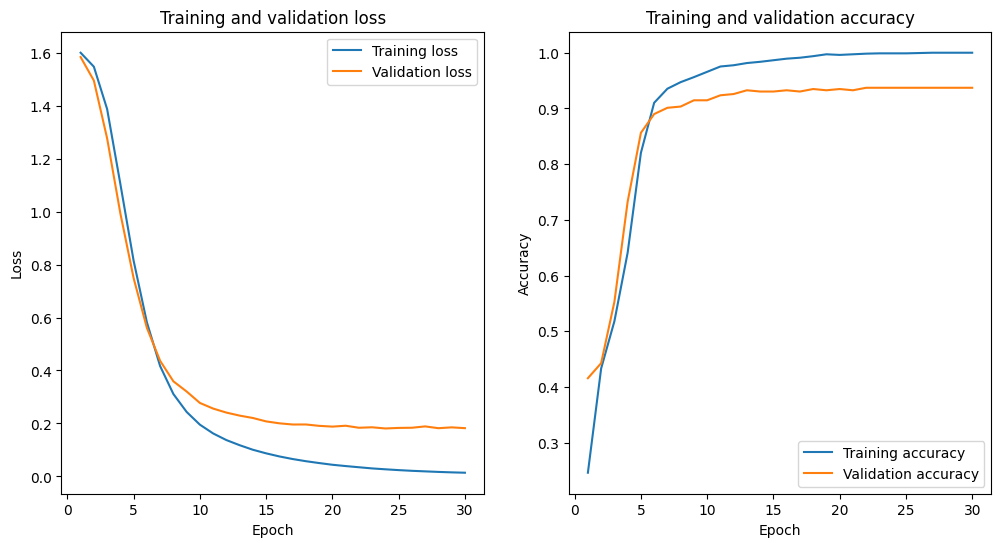

In [20]:
from math import ceil

def plot_params(params: list[str]=[], validation=True):
  num_params = len(params)
  num_rows = ceil(num_params/2)
  epochs = [epoch for epoch in range(1, len(history.history[params[0]])+1)]
  plt.figure(figsize=(12, 6*num_rows))
  for i in range(0, num_params):
    s = plt.subplot(num_rows, 2, i+1)
    par = params[i]
    s.plot(epochs, history.history[par], label=f'Training {par}')
    # s.set_xticks(epochs)
    s.set_xlabel('Epoch')
    s.set_ylabel(par.capitalize())
    if validation:
      s.plot(epochs, history.history[f'val_{par}'], label=f'Validation {par}')
      s.set_title(f'Training and validation {par}')
    else:
      s.set_title(f'Training {par}')
    s.legend()

plot_params(['loss', 'accuracy'])

## Visualizing Embedding 3D Vectors

In [21]:
# Reverse word index
reverse_word_index = tokenizer.index_word

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


In [24]:
# Generate files for embedding visualization
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()